In [21]:
from DOPU_given_timerange import get_cleaned_df
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

NUMBER_OF_ZONES = 265

In [3]:
get_cleaned_df()

Processing files: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


In [4]:
df = pd.read_parquet("all_cleaned_data/all_cleaned_data.parquet", engine='fastparquet')
df.head()

,VendorID,PickupDatetime,DropoffDatetime,TripDuration,PassengerCount,TripDistance,PULocationID,DOLocationID,PaymentType,FareAmount,ExtraCharges,MTATax,TipAmount,TollsAmount,ImprovementSurcharge,TotalAmount,CongestionSurcharge,AirportFee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,8.433333,1.0,0.97,161,141,2,9.3,1.0,0.5,0.00,0.0,1.0,14.300000,2.5,0.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,6.316667,1.0,1.10,43,237,1,7.9,1.0,0.5,4.00,0.0,1.0,16.900000,2.5,0.0
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,12.750000,1.0,2.51,48,238,1,14.9,1.0,0.5,15.00,0.0,1.0,34.900002,2.5,0.0
3,2,2023-01-01 00:10:29,2023-01-01 00:21:19,10.833333,1.0,1.43,107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.680000,2.5,0.0
4,2,2023-01-01 00:50:34,2023-01-01 01:02:52,12.300000,1.0,1.84,161,137,1,12.8,1.0,0.5,10.00,0.0,1.0,27.799999,2.5,0.0


In [ ]:
def generate_intra_zone_matrix(df, save_path='intra_zone_matrix.npy', force_recompute=False):
    if os.path.exists(save_path) and not force_recompute:
        print(f"Loading precomputed matrix from '{save_path}'...")
        return np.load(save_path)

    print("Instancing matrix...")
    matrix = np.full((NUMBER_OF_ZONES+1, NUMBER_OF_ZONES+1, 4), np.nan, dtype=np.float16)

    print("Grouping data...")
    grouped = df.groupby(['PULocationID', 'DOLocationID'])
    
    for (pu, do), group in tqdm(grouped, desc="Filling in matrix..."):
        matrix[pu, do, 0] = group['TripDuration'].mean()
        matrix[pu, do, 1] = group['TripDuration'].std()
        matrix[pu, do, 2] = group['TripDistance'].mean()
        matrix[pu, do, 3] = group['TripDistance'].std()

    np.save(save_path, matrix)
    print(f"Matrix saved to '{save_path}'.")

    return matrix

In [51]:
intra_zone_matrix = generate_intra_zone_matrix(df, force_recompute=True)

Instancing matrix...
Grouping data...


Filling in matrix...: 100%|██████████| 48305/48305 [01:26<00:00, 559.59it/s] 


Matrix saved to 'intra_zone_matrix.npy'.


Min value for 0: 1.0
Max value for 0: 179.75
Min value for 1: 0.0
Max value for 1: 101.375
Min value for 2: 0.07000732421875
Max value for 2: 49.875
Min value for 3: 0.0
Max value for 3: 27.5
Percentage of filled entries: 68.53%
Most empty zones: [175  98 104  83   1 203 102 103 109 198]


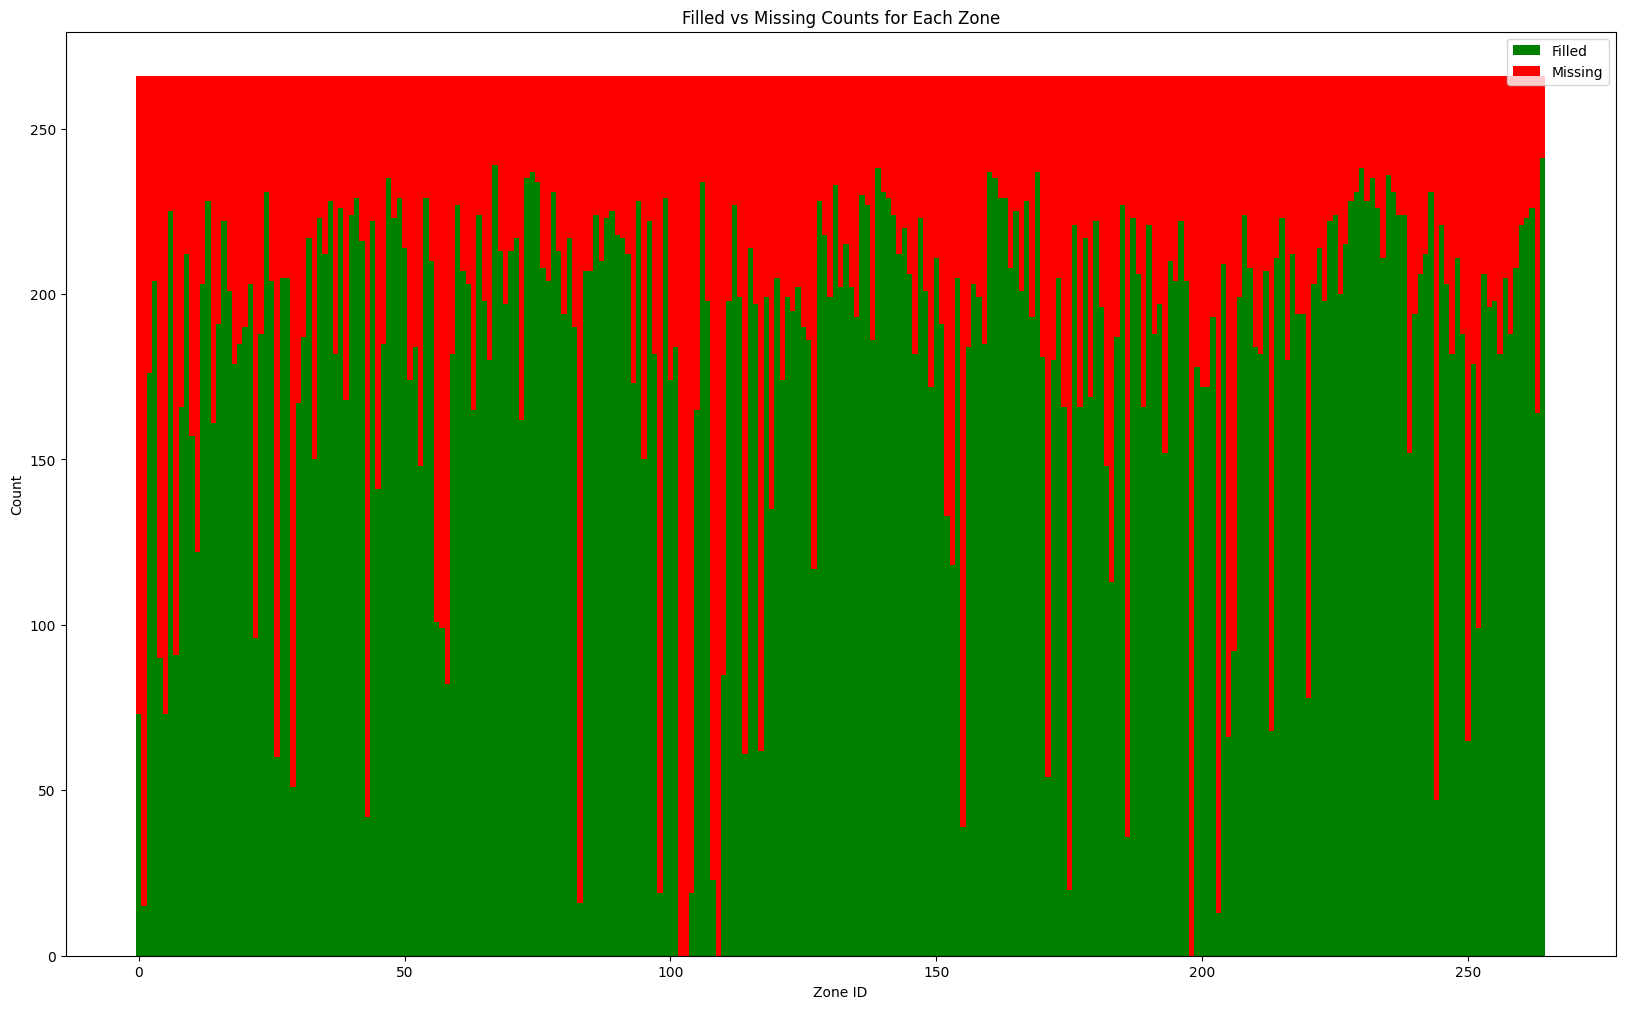

In [53]:
missing_counts = np.isnan(intra_zone_matrix[:, :, 0]).sum(axis=0)
filled_counts = (~np.isnan(intra_zone_matrix[:, :, 0])).sum(axis=0)

# Chop off the first entry since the 0th zone doesn't exist
filled_counts = filled_counts[1:]
missing_counts = missing_counts[1:]

# Print min and max values (not inf) for each 3rd axis
for i in range(4):
    print(f"Min value for {i}: {np.min(intra_zone_matrix[:, :, i][~np.isnan(intra_zone_matrix[:, :, i])])}")
    print(f"Max value for {i}: {np.max(intra_zone_matrix[:, :, i][~np.isnan(intra_zone_matrix[:, :, i])])}")

print(f"Percentage of filled entries: {np.sum(filled_counts) / (np.sum(filled_counts) + np.sum(missing_counts)) * 100:.2f}%")

print(f"Most empty zones: {np.argsort(missing_counts)[-10:]}")

plt.figure(figsize=(20, 12))
plt.bar(range(NUMBER_OF_ZONES), filled_counts, width=1.0, label='Filled', color='green')
plt.bar(range(NUMBER_OF_ZONES), missing_counts, width=1.0, bottom=filled_counts, label='Missing', color='red')
plt.xlabel('Zone ID')
plt.ylabel('Count')
plt.title('Filled vs Missing Counts for Each Zone')
plt.legend()
plt.show()

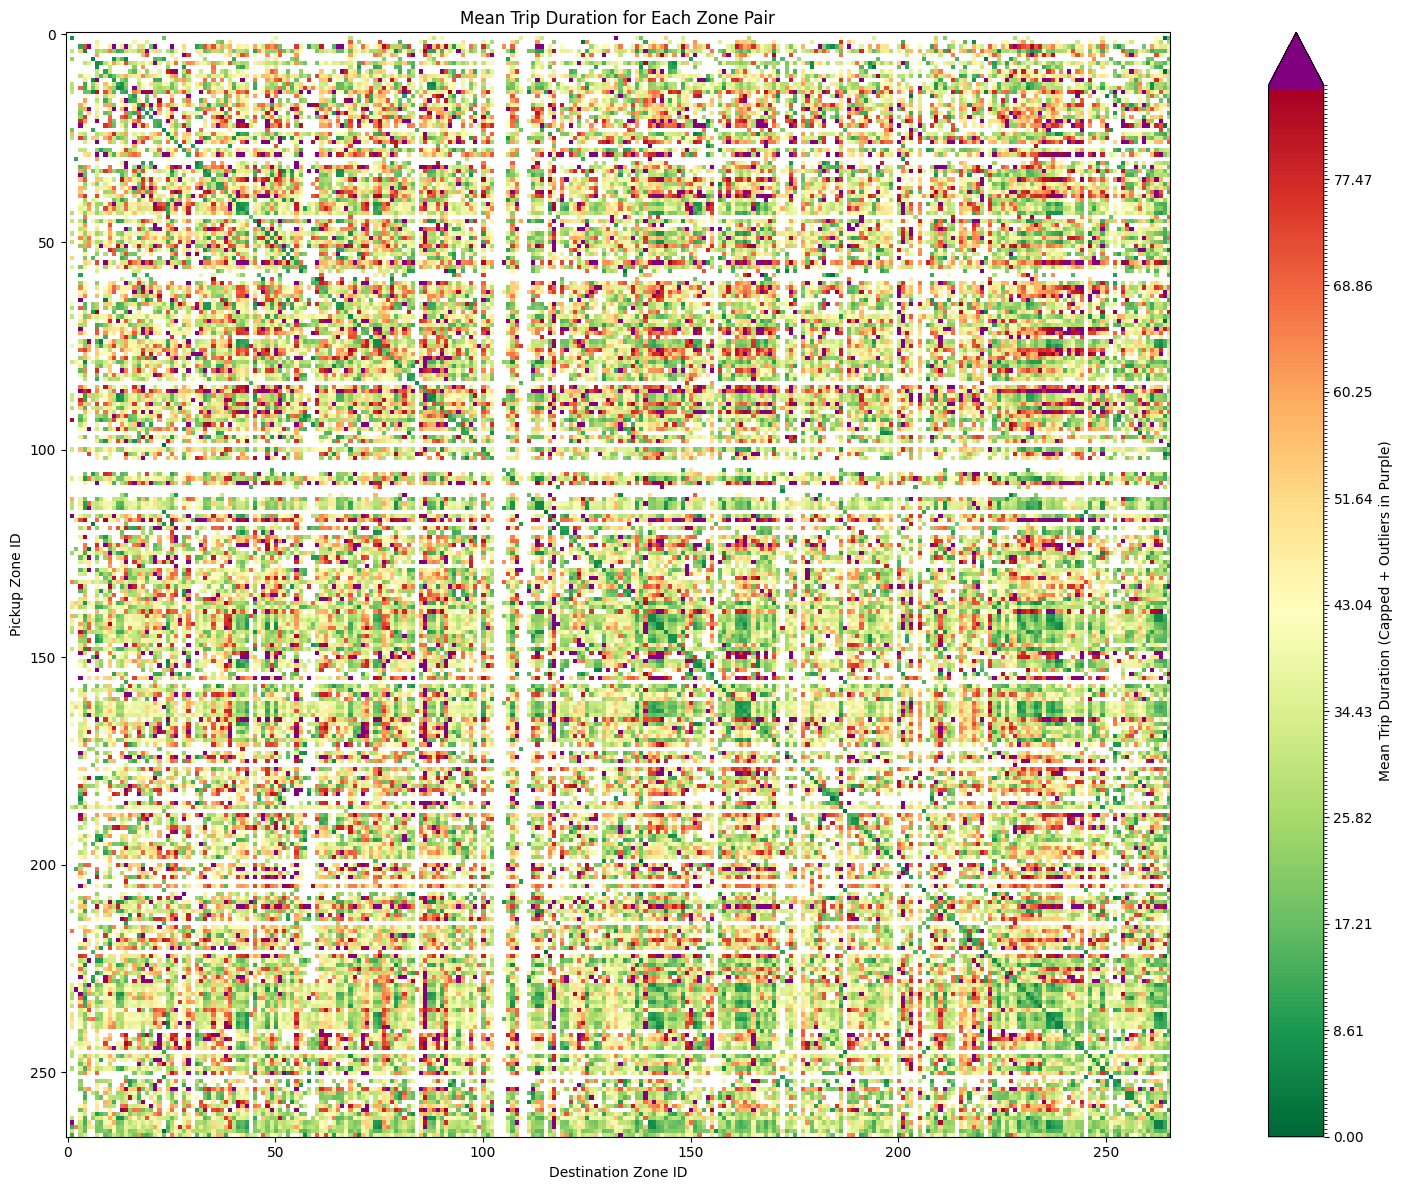

In [54]:
trip_distance_duration_matrix = intra_zone_matrix[:, :, 0]
clean_matrix = np.where(np.isinf(trip_distance_duration_matrix), np.nan, trip_distance_duration_matrix)

valid_values = clean_matrix[~np.isnan(clean_matrix)]
cap_value = np.percentile(valid_values, 95)
median_value = np.median(valid_values)

# Create a mask for missing, normal, and outlier entries
missing_mask = np.isnan(clean_matrix)
outlier_mask = clean_matrix > cap_value
normal_mask = ~(missing_mask | outlier_mask)

# Create a new plotting matrix
plot_matrix = np.full_like(clean_matrix, np.nan)

plot_matrix[normal_mask] = np.clip(clean_matrix[normal_mask], 0, cap_value)
outlier_value = cap_value + 1
plot_matrix[outlier_mask] = outlier_value

# RdYlGn for normal values, purple for outliers, transparent for NaNs
base_cmap = plt.get_cmap('RdYlGn_r', 256)
colors = base_cmap(np.linspace(0, 1, 256))
purple = np.array([[128/255, 0, 128/255, 1]])
colors = np.vstack([colors, purple])
custom_cmap = ListedColormap(colors)

bounds = np.linspace(0, cap_value, 257)
bounds = np.append(bounds, outlier_value + 1)
norm = BoundaryNorm(boundaries=bounds, ncolors=custom_cmap.N)

plt.figure(figsize=(20, 12))
im = plt.imshow(plot_matrix, cmap=custom_cmap, norm=norm, interpolation='nearest')

cbar = plt.colorbar(im, extend='max')
cbar.set_label('Mean Trip Duration (Capped + Outliers in Purple)')

plt.title('Mean Trip Duration for Each Zone Pair')
plt.xlabel('Destination Zone ID')
plt.ylabel('Pickup Zone ID')
plt.tight_layout()
plt.show()